In [1]:
# Change the dataset in global_vars.py to KORA.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None # ['KORA2460830', 'KORA2460249']
exclude = ['KORA2460249']
# KORA2455042, 365, test:no-gallbladder=KORA2453290
%load_ext autoreload
%autoreload 2

In [2]:
# os.listdir(label_dir)

In [3]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for namelabel in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_kora_file_paths()
file_paths

{'KORA2459728': {'VOLUME_PATHS': {'OPP': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz',
    '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'],
   'IN': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz',
    '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz'],
   'F': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_1.nii.gz',
    '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_2.nii.gz'],
   'W': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_3.nii.gz',
    '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_4.nii.gz']},
  'LABEL_PATHS'

In [4]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [5]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [6]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    try:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
        print(f'started with {vol}...')
        create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
        file_paths[vol]['ONE'] = {}
        for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
            print(f"processing {modality_key}")
            orig_modal_key = modality_key
            if one_time_n4_optimization:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
            else:
                if modality_key == 'OPP':
                    vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                    modality_key = modality_key+'_n4_corrected'
                else:
                    vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

            ras_stitched_resampled = multi_vol_stitching(vol_parts)
            save_volume(ras_stitched_resampled, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
            file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
    except Exception as e:
        print('ERROR:',e)
        continue

started with KORA2459728...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         259.62518311]
 [  0.           0.          -1.70000458 124.04505157]
 [  0.          -1.70138884   0.         -89.33918762]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          254.62518311]
 [   0.            0.           -1.70000458  124.04505157]
 [   0.           -1.66666663    0.         -324.33920288]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2459728
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         259.62518311]
 [  0.           0

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460408
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         245.00086975]
 [  0.           0.          -1.69999695 116.78907013]
 [  0.          -1.70138884   0.         -55.16016388]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          240.00086975]
 [   0.            0.           -1.69999695  116.78907013]
 [   0.           -1.66666663    0.         -290.16015625]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460408
p

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2458366
started with KORA2453363...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.70138884    0.            0.          234.75933838]
 [   0.            0.           -1.70000458  113.41820526]
 [   0.           -1.70138884    0.         -106.41783905]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          229.75933838]
 [   0.            0.           -1.70000458  113.41820526]
 [   0.           -1.66666663    0.         -341.41784668]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentati

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460734
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         242.58334351]
 [  0.           0.          -1.69999695 140.065979  ]
 [  0.          -1.70138884   0.          -9.54386711]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          237.58334351]
 [   0.            0.           -1.69999695  140.065979  ]
 [   0.           -1.66666663    0.         -244.54386902]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460734
p

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2462026
started with KORA2462405...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         240.15220642]
 [  0.           0.          -1.69999695 121.61049652]
 [  0.          -1.70138884   0.          -6.47939968]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          235.15220642]
 [   0.            0.           -1.69999695  121.61049652]
 [   0.           -1.66666663    0.         -241.47940063]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2453229
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         262.03250122]
 [  0.           0.          -1.69999695 152.1910553 ]
 [  0.          -1.70138884   0.           0.52120578]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          257.03250122]
 [   0.            0.           -1.69999695  152.1910553 ]
 [   0.           -1.66666663    0.         -234.47879028]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2453229
p

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2453578
started with KORA2459908...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         244.99746704]
 [  0.           0.          -1.70000458 107.04406738]
 [  0.          -1.70138884   0.         -16.56830788]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          239.99746704]
 [   0.            0.           -1.70000458  107.04406738]
 [   0.           -1.66666663    0.         -251.56829834]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4

Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460723
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         235.24905396]
 [  0.           0.          -1.69999695 109.47180176]
 [  0.          -1.70138884   0.          31.96945   ]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          230.24905396]
 [   0.            0.           -1.69999695  109.47180176]
 [   0.           -1.66666663    0.         -203.0305481 ]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 160)
Transforming Images to RAS.....
0th img for stitching...
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2460723
p

In [7]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    try:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
        print(f'n4 processing part-2 started with {vol}...')
        n4_dict[vol] = {}
        in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
        n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)
    except Exception as e:
        print('ERROR:',e)
        continue

n4 processing part-2 started with KORA2459728...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -228.67341614]
 [   0.            2.            0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)
Transforming Images to RAS.....
-76.17095184326172
neagtive value detected
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2459728
n4 processing part-2 started with KORA2453290...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -243.28752136]
 [   0.            2.            0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)
Transforming Images to RAS.....
-79.55612182617188
neagtive value detected
saving

n4 processing part-2 started with KORA2459908...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -243.3011322 ]
 [   0.            2.            0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)
Transforming Images to RAS.....
-81.56536865234375
neagtive value detected
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/n4_corrected_2/vol/KORA2459908
n4 processing part-2 started with KORA2460830...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -204.32450867]
 [   0.            2.            0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)
Transforming Images to RAS.....
-95.47589874267578
neagtive value detected
saving

In [14]:
all_n4_process = True
for vol in file_paths.keys():
    try:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
        print(f'n4-biasfield-correction starting with {vol}...')
        in_file = n4_dict[vol]['N4_2']['SCALED']
        opp_file = file_paths[vol]['ONE']['OPP']
        if all_n4_process:
            w_file = file_paths[vol]['ONE']['W']
            w_of = w_file.split('/')[-1].split('.')[0]
            w_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{w_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, w_file, w_outputfile)
            n4_dict[vol]['N4_2']['W_CORRECTED'] = w_outputfile
            
            f_file = file_paths[vol]['ONE']['F']
            f_of = f_file.split('/')[-1].split('.')[0]
            f_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{f_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, f_file, f_outputfile)
            n4_dict[vol]['N4_2']['F_CORRECTED'] = f_outputfile
            
            inin_file = file_paths[vol]['ONE']['IN']
            in_of = inin_file.split('/')[-1].split('.')[0]
            in_outputfile = f'{n4_corrected_data_dir}/vol/{vol}/{in_of}_n4_corrected_sitk.nii.gz'
            SITK_N4_normalization(in_file, inin_file, in_outputfile)
            n4_dict[vol]['N4_2']['IN_CORRECTED'] = in_outputfile
            
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
        
        file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']
    except Exception as e:
        print('ERROR:',e)
        continue

n4-biasfield-correction starting with KORA2459728...
done
done
done
done
n4-biasfield-correction starting with KORA2453290...
done
done
done
done
n4-biasfield-correction starting with KORA2460408...
done
done
done
done
n4-biasfield-correction starting with KORA2452879...
done
done
done
done
n4-biasfield-correction starting with KORA2458366...
done
done
done
done
n4-biasfield-correction starting with KORA2453363...
done
done
done
done
n4-biasfield-correction starting with KORA2456120...
done
done
done
done
n4-biasfield-correction starting with KORA2460734...
done
done
done
done
n4-biasfield-correction starting with KORA2459745...
done
done
done
done
n4-biasfield-correction starting with KORA2462026...
done
done
done
done
n4-biasfield-correction starting with KORA2462405...
done
done
done
done
n4-biasfield-correction starting with KORA2456289...
done
done
done
done
n4-biasfield-correction starting with KORA2453229...
done
done
done
done
n4-biasfield-correction starting with KORA2453666..

In [15]:
print(file_paths)

{'KORA2459728': {'VOLUME_PATHS': {'OPP': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz', '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'], 'IN': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz', '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz'], 'F': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_1.nii.gz', '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_2.nii.gz'], 'W': ['/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_3.nii.gz', '/mnt/nas/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2459728/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_4.nii.gz']}, 'LABEL_PATHS': ['datasets/lablmaps/KORA/

In [16]:
def kora_vol_label_fix(vol, label, use_alternate_approach=False):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))

    ld = label.get_fdata()
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, 0:sz+ez] = ld
    else:
        final_label[0:sx+ex, 0:sy+ey, 77:77+76] = ld[:, :, :76]
        
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=2)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    
    return vol, final_label_img

def kora_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
        
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

In [17]:
# import pickle as p
# with open('new_oksana_kora_file_paths.p', 'wb') as handle:
#     p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [18]:
# import pickle as p
# with open('new_oksana_kora_file_paths.p', 'rb') as handle:
#     file_paths = p.load(handle)

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
KORA2459728
['datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-6.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8KIDNEY(L

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_PANCREAS.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/KORA/KORA2459728/2459728_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-6.NRRD_

/home/abhijit/anaconda3/envs/remotenv/lib/python3.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


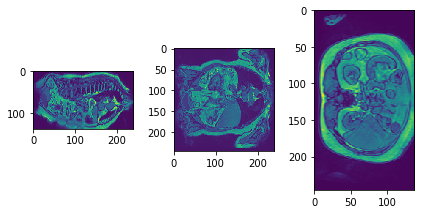

Affine:[[   2.            0.           -0.         -228.67341614]
 [   0.            2.           -0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


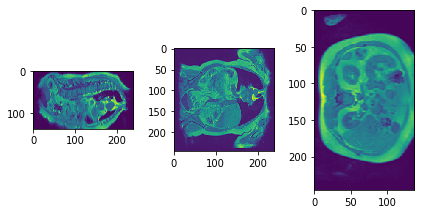

Affine:[[   2.            0.           -0.         -228.67341614]
 [   0.            2.           -0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


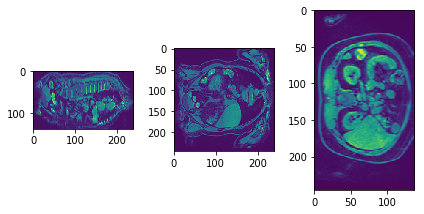

Affine:[[   2.            0.           -0.         -228.67341614]
 [   0.            2.           -0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


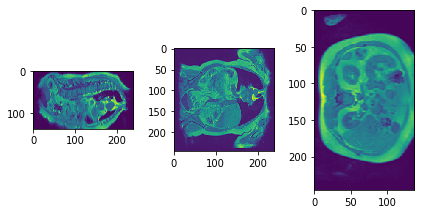

Affine:[[   2.            0.           -0.         -228.67341614]
 [   0.            2.           -0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


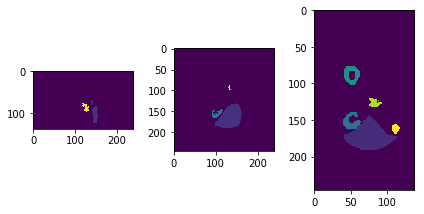

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2453290
['datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (right).nrrd', 'datasets/lablmaps/KO

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453290/2453290_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-13_PANCREAS.NRRD
SPL DATASETS/LABLM

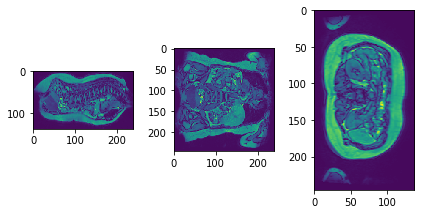

Affine:[[   2.            0.           -0.         -243.28752136]
 [   0.            2.           -0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


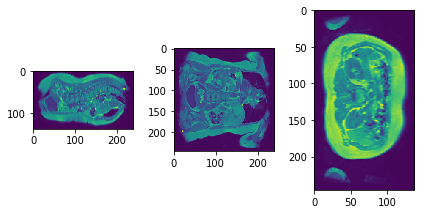

Affine:[[   2.            0.           -0.         -243.28752136]
 [   0.            2.           -0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


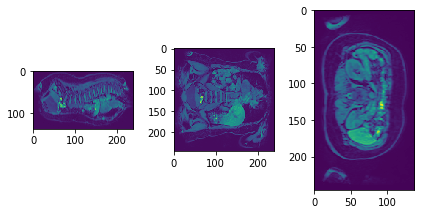

Affine:[[   2.            0.           -0.         -243.28752136]
 [   0.            2.           -0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


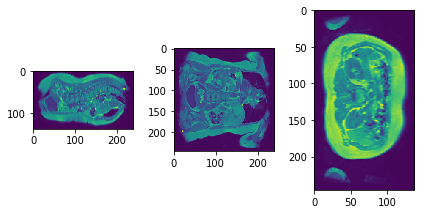

Affine:[[   2.            0.           -0.         -243.28752136]
 [   0.            2.           -0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


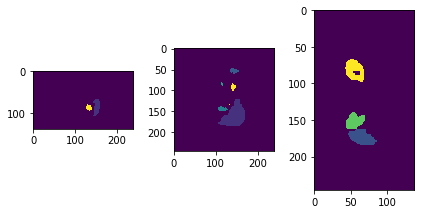

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2460408
['datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_Kidney(right).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2460408/2460408_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2460408/246

###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
102 SPLEEN
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 209.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 2. 3.]
segm spacing:  [2. 2. 3.]
im dim w:  [492. 274. 717.]
segm dim w:  [492. 274. 492.]
im off:  [ 243.29773  153.51044 -768.49347]
segm off:  [245.00087  387.3099   -55.160164]
im start:  [ 243.29773  153.51044 -768.49347]
im end:  [-248.70227051 -120.48956299  -51.49346924]
segm start:  [245.00087  387.3099   -55.160164]
segm end:  [-246.99913025  113.30990601  436.83983612]
start diff w:  [  1.703

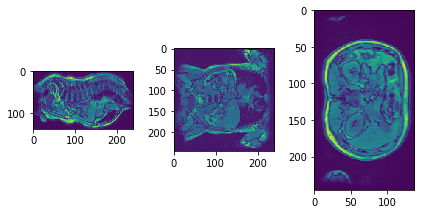

Affine:[[   2.            0.           -0.         -243.29772949]
 [   0.            2.           -0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


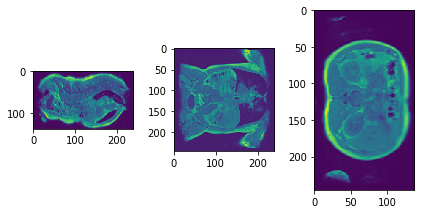

Affine:[[   2.            0.           -0.         -243.29772949]
 [   0.            2.           -0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


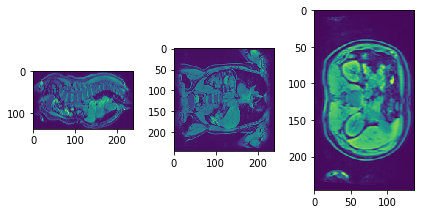

Affine:[[   2.            0.           -0.         -243.29772949]
 [   0.            2.           -0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


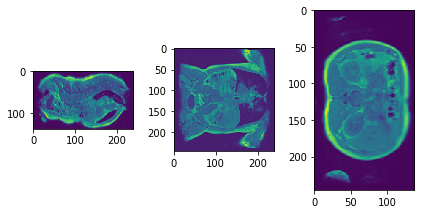

Affine:[[   2.            0.           -0.         -243.29772949]
 [   0.            2.           -0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


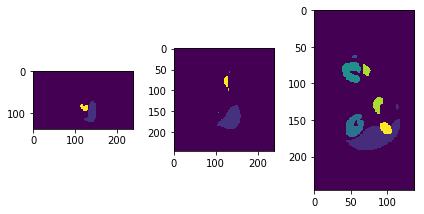

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2452879
['datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidn

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2452879/2452879_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2452879/2452879_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2452879/2452879_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2452879/2452879_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2452879/2452879_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA245

###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 

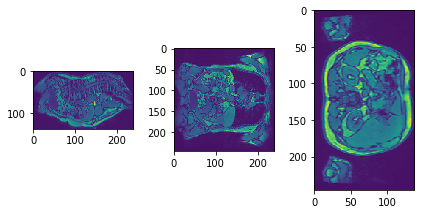

Affine:[[   2.            0.           -0.         -243.27729797]
 [   0.            2.           -0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


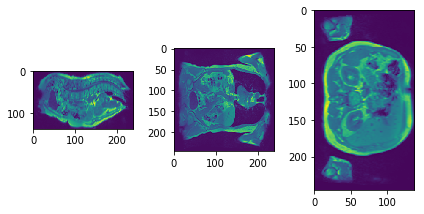

Affine:[[   2.            0.           -0.         -243.27729797]
 [   0.            2.           -0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


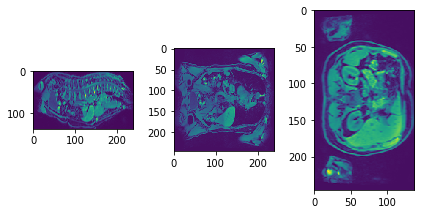

Affine:[[   2.            0.           -0.         -243.27729797]
 [   0.            2.           -0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


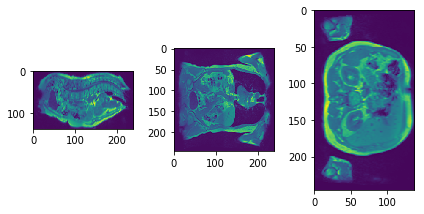

Affine:[[   2.            0.           -0.         -243.27729797]
 [   0.            2.           -0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


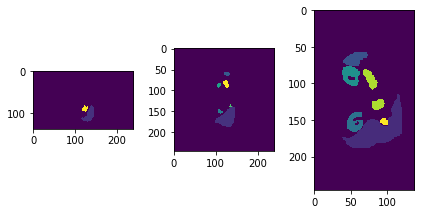

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2458366
['datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidn

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2458366/2458366_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2458366/2458366_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2458366/2458366_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2458366/2458366_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2458366/2458366_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/L

###############################################################################################
102 SPLEEN
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
101 LIVER
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 150, 239)
segm dim v:  (246, 150, 164)
im spacing:  [2. 2. 3.]
s

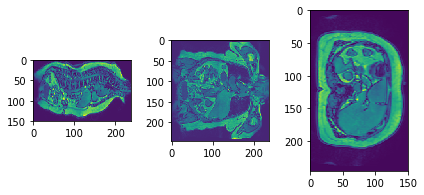

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


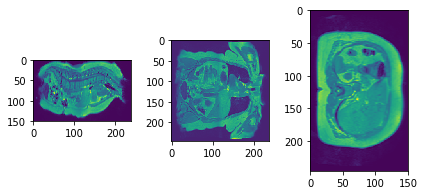

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


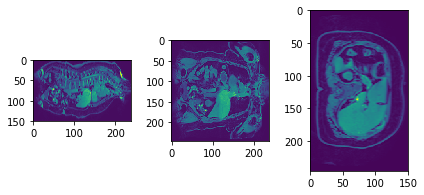

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


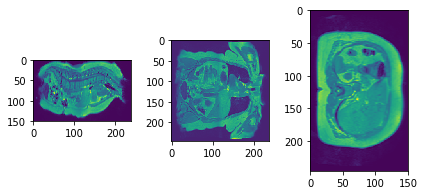

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


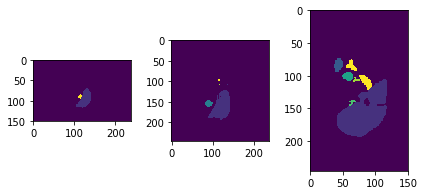

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2453363
['datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_8.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_appl

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NRRD_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NRRD_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NRR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NII_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453363/2453363_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_8.NII_LIVER.NRRD
[True] True
104 KIDNEY(LEFT)
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
1

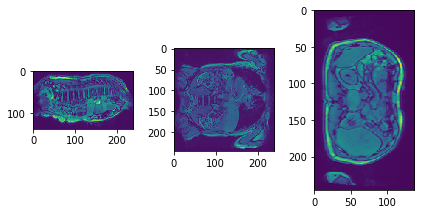

Affine:[[   2.            0.           -0.         -253.53926086]
 [   0.            2.           -0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


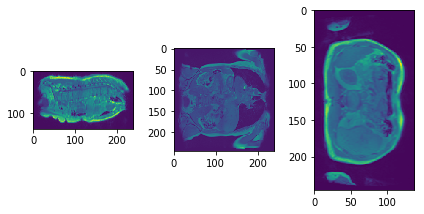

Affine:[[   2.            0.           -0.         -253.53926086]
 [   0.            2.           -0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


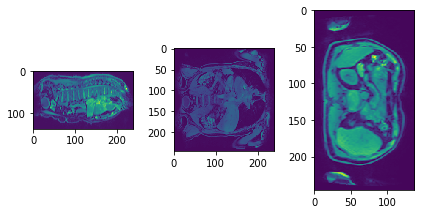

Affine:[[   2.            0.           -0.         -253.53926086]
 [   0.            2.           -0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


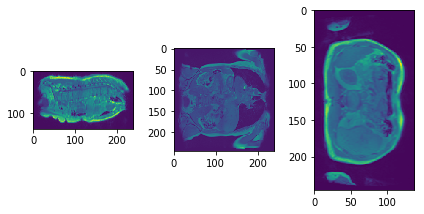

Affine:[[   2.            0.           -0.         -253.53926086]
 [   0.            2.           -0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


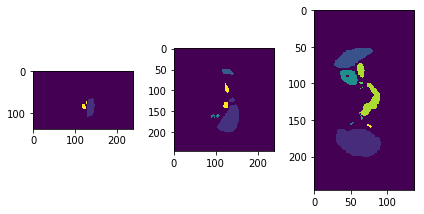

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2456120
['datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidn

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KO

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2456120/2456120_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
KIDNEY(RI

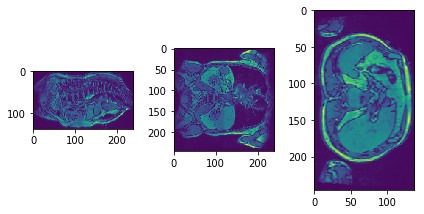

Affine:[[   2.            0.           -0.         -250.58435059]
 [   0.            2.           -0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


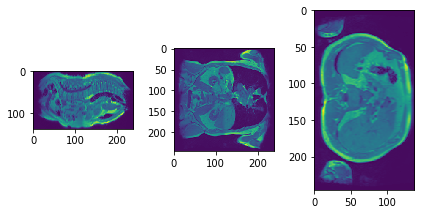

Affine:[[   2.            0.           -0.         -250.58435059]
 [   0.            2.           -0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


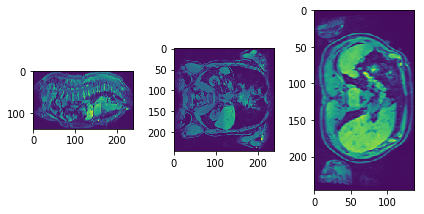

Affine:[[   2.            0.           -0.         -250.58435059]
 [   0.            2.           -0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


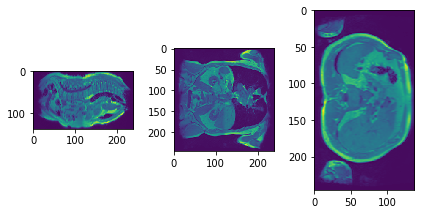

Affine:[[   2.            0.           -0.         -250.58435059]
 [   0.            2.           -0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


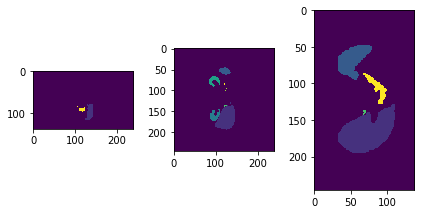

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2460734
['datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_correct

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2460734/246

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2460734/2460734_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KO

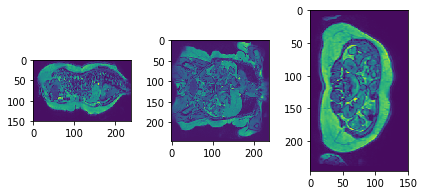

Affine:[[   2.            0.           -0.         -245.71525574]
 [   0.            2.           -0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


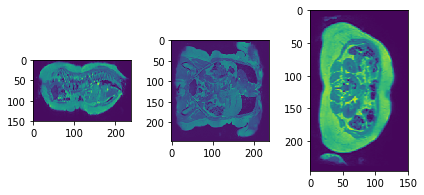

Affine:[[   2.            0.           -0.         -245.71525574]
 [   0.            2.           -0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


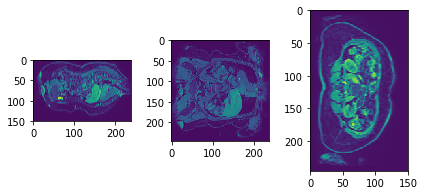

Affine:[[   2.            0.           -0.         -245.71525574]
 [   0.            2.           -0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


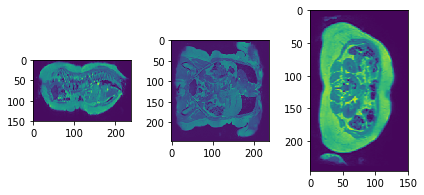

Affine:[[   2.            0.           -0.         -245.71525574]
 [   0.            2.           -0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


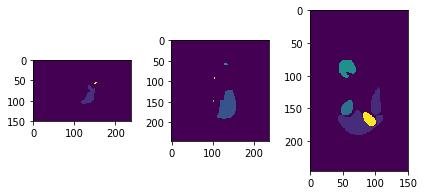

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2459745
['datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Pa

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459745/2459745_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459745/2459745_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_LIVER.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459745/2459745_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459745/2459745_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2459745/2459745_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2459

105 ADRENAL(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
101 LIVER
###############################################################################################
108 GALLBLADDER
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spac

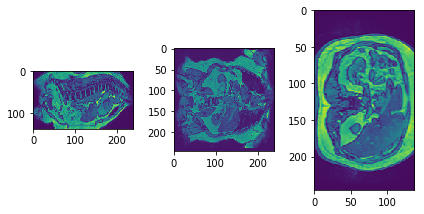

Affine:[[   2.            0.           -0.         -238.42182922]
 [   0.            2.           -0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


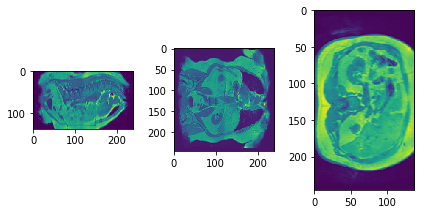

Affine:[[   2.            0.           -0.         -238.42182922]
 [   0.            2.           -0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


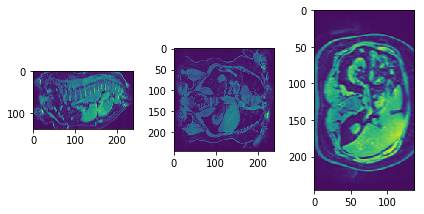

Affine:[[   2.            0.           -0.         -238.42182922]
 [   0.            2.           -0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


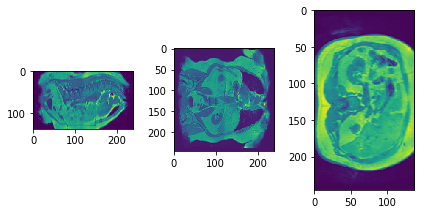

Affine:[[   2.            0.           -0.         -238.42182922]
 [   0.            2.           -0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


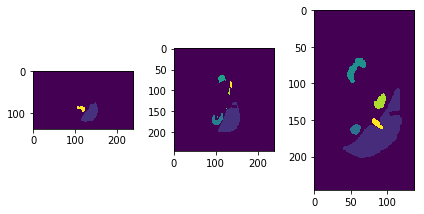

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2462026
['datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney(links).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Pancreas.nr

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2462026/2462026_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(LINKS).NRRD
KIDNEY(RIGHT) DATASETS/L

###############################################################################################
101 LIVER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
108 GALLBLADDER
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 204.0
Overlapped Idxs Found, removing

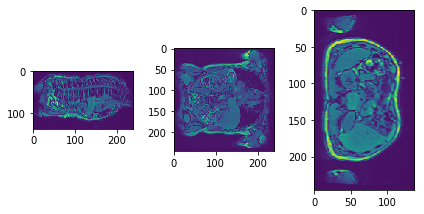

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


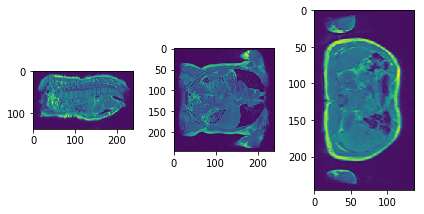

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


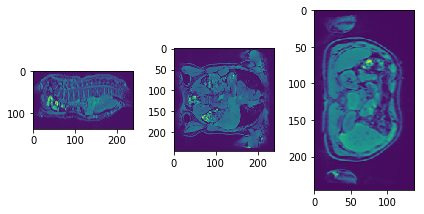

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


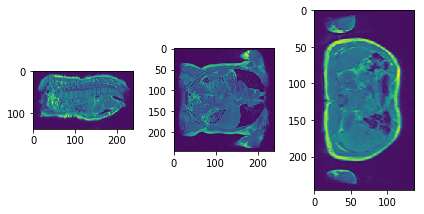

Affine:[[   2.            0.           -0.         -245.71185303]
 [   0.            2.           -0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


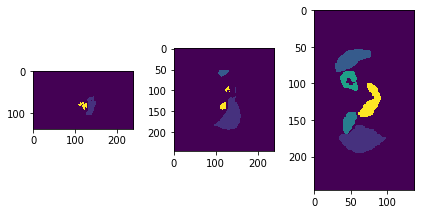

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2462405
['datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Panc

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2462405/2462405_T1

###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
108 GALLBLADDER
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 

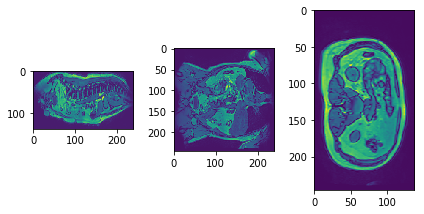

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


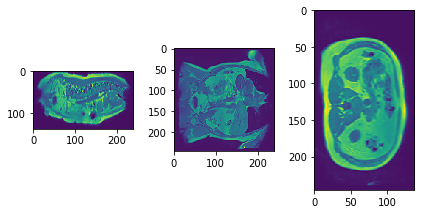

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


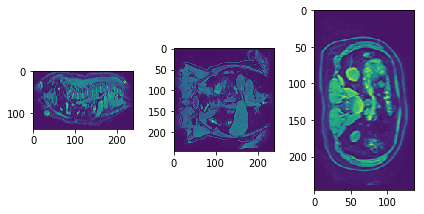

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


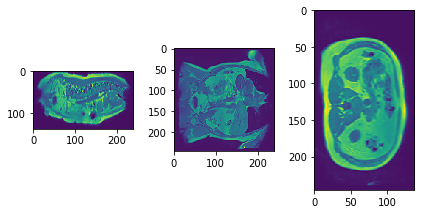

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


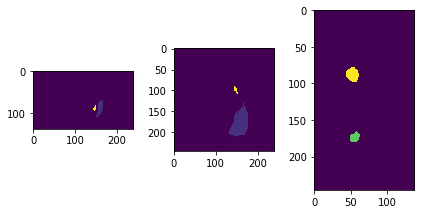

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2456289
['datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_correct

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2456289/2456289_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[F

###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
101 LIVER
###############################################################################################
108 GALLBLADDER
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 209.0
Overlapped Idxs Found, removing 

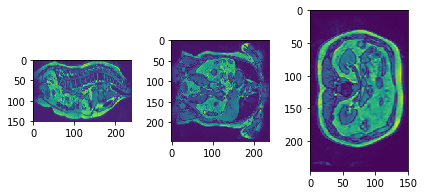

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


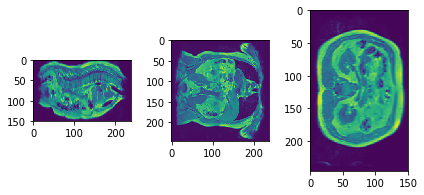

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


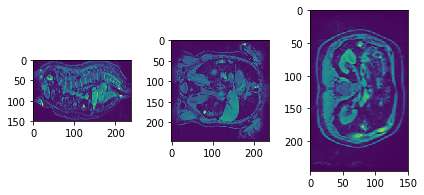

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


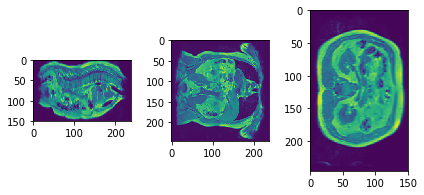

Affine:[[   2.            0.           -0.         -253.02911377]
 [   0.            2.           -0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


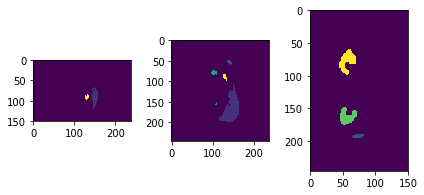

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2453229
['datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm.nii_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_correcte

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM.NII_PANCREAS.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/KORA/KORA2453229/2453229_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_O

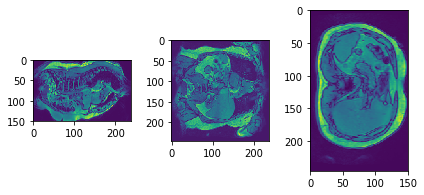

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


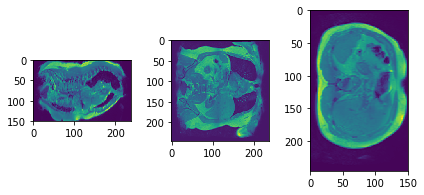

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


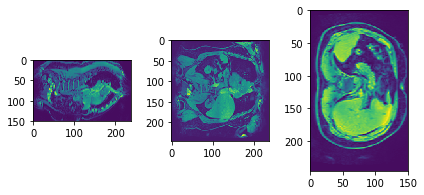

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


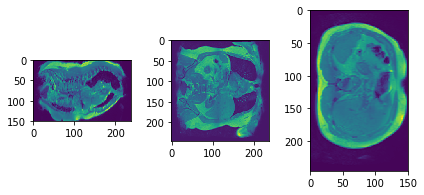

Affine:[[   2.            0.           -0.         -226.26609802]
 [   0.            2.           -0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


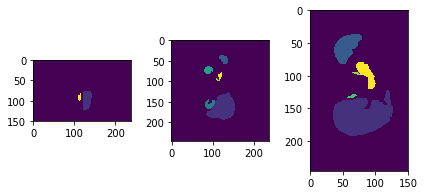

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2453666
['datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected_Kidney (le

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453666/2453666_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED_ADRENALGLAND(RIGHT).NRRD
[F

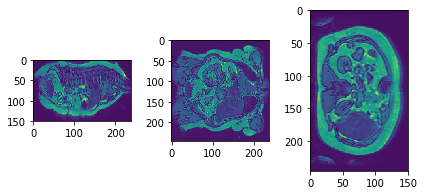

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


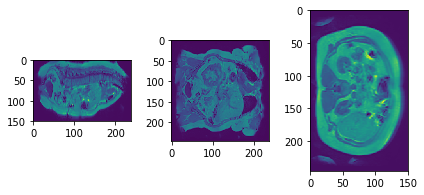

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


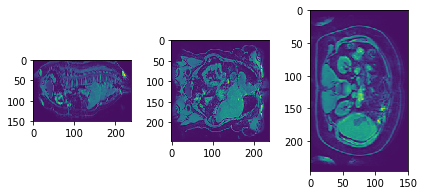

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


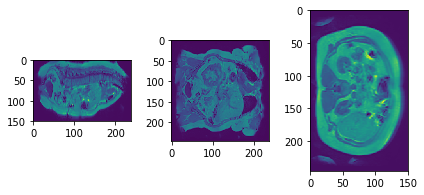

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -147.78381348]
 [   0.            0.            3.         -724.9473877 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


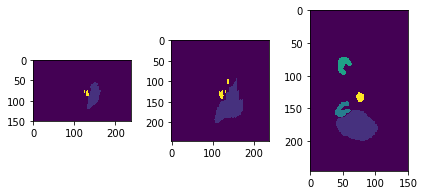

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2453578
['datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Kidney (right) -3.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_corrected.nii_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_corrected_comb_sigm_rescaled_applied_in_bias_correct

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2453578/2453578_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_CORRECTED_COMB_SIGM_RESCALED_APPLIED_IN_BIAS_CORRECTED.NII_GALLBLADDER-3.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/KO

###############################################################################################
101 LIVER
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
102 SPLEEN
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (246, 137, 239)
segm dim v:  (246, 137, 164)
im spacing:  [2. 2. 3.]
s

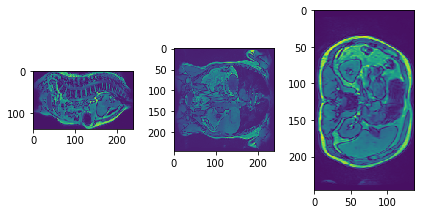

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


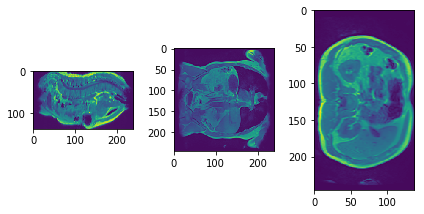

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


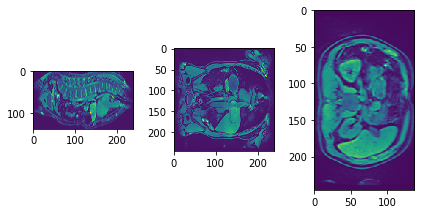

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


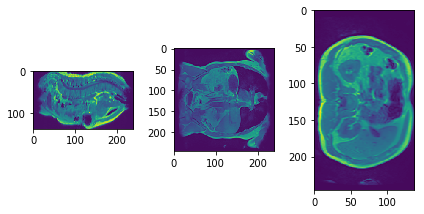

Affine:[[   2.            0.           -0.         -248.14639282]
 [   0.            2.           -0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


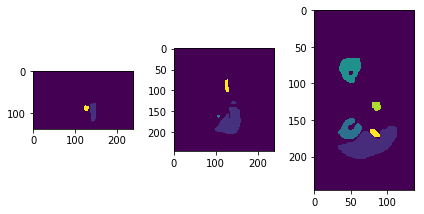

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2459908
['datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Liver-2.nrrd', 'datasets/lablmaps/KORA/

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_LIVER-2.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_LIVER-2.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2459908/2459908_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8-3_KIDNEY(RIG

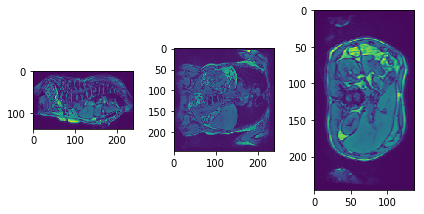

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


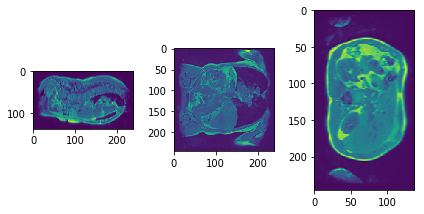

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


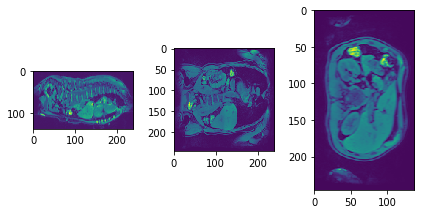

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


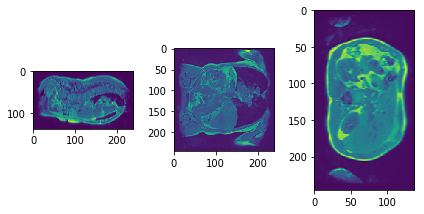

Affine:[[   2.            0.           -0.         -243.3011322 ]
 [   0.            2.           -0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


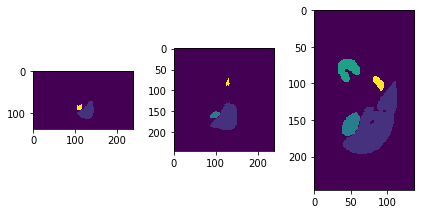

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2460830
['datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_10_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KOR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9.NII_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9.NII_LIVER.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/KORA/KORA2460830/2460830_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_9_KIDNEY(LEFT).NRRD
KIDNEY

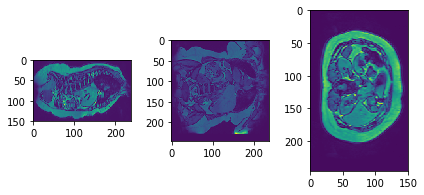

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


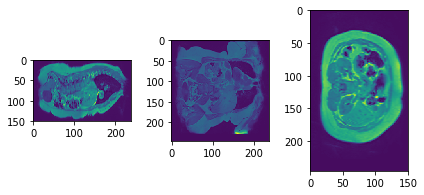

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


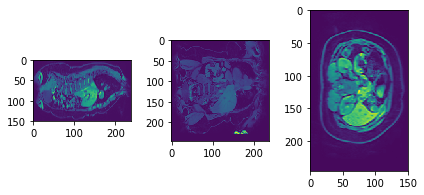

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


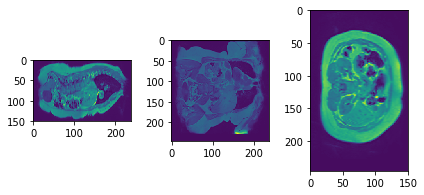

Affine:[[   2.            0.           -0.         -204.32450867]
 [   0.            2.           -0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


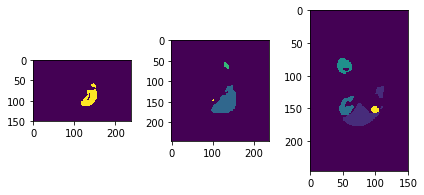

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
KORA2460723
['datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-25.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-26.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/l

Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI6_BH_288_ISO_OPP_8_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/KORA/KORA2460723/2460723_T1_VIBE_DIXON_COR_CAIPI

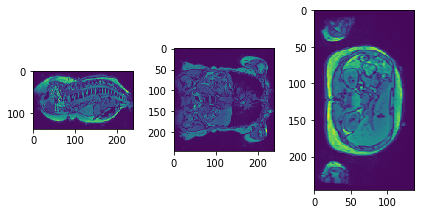

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


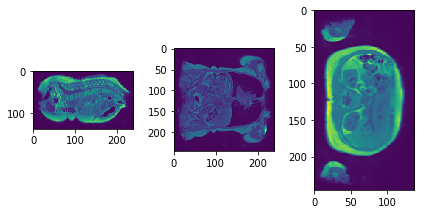

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


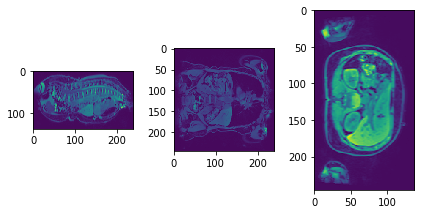

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


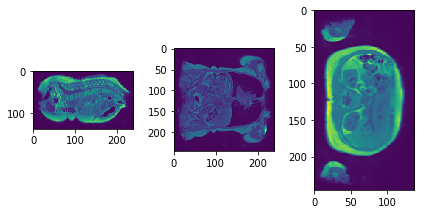

Affine:[[   2.            0.           -0.         -253.04954529]
 [   0.            2.           -0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


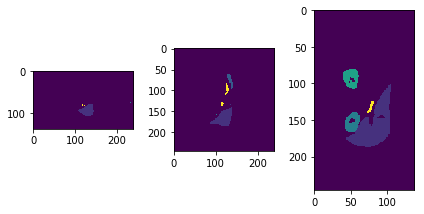

Saving Processed & Stitched Image.....
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_f
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_w
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/volume_in
saving directory: /mnt/nas/Abhijit/Jyotirmay/abdominal_segmentation/temp2/KORA/processed/label
FINISHED.


In [13]:
# exclude = ['KORA2460249', 'KORA2456120'] #, 'KORA2456120',  'KORA2462026']
# vol_to_check_list = None #['KORA2452879', 'KORA2456120']
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
skip = True
for vol in file_paths.keys():
    print(vol)
    if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
#     if vol == 'KORA2462026':
#         skip = False
#     if skip:
#         continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    f_volume = nb.load(file_paths[vol]['N4_2']['F_CORRECTED'])
    w_volume = nb.load(file_paths[vol]['N4_2']['W_CORRECTED'])
    in_volume = nb.load(file_paths[vol]['N4_2']['IN_CORRECTED'])
#     ref_vol = nb.load(file_paths[vol]['ONE_ORIG']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        if labelname in ['PANCREAS']:
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = kora_label_parts(img_ras_list)
    s_label = resample_to_output(s_label, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    
    if vol == 'KORA2460249':
        volume, s_label = kora_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = kora_vol_label_fix(volume, s_label)
    
    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(f_volume))
    volume_3_view_viewer(get_volume_data(w_volume))
    volume_3_view_viewer(get_volume_data(in_volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(f_volume, f'{processed_dir}/volume_f/{vol}')
    save_volume(w_volume, f'{processed_dir}/volume_w/{vol}')
    save_volume(in_volume, f'{processed_dir}/volume_in/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')
